In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *
from check_inferred_embeddings import *
from check_inferred_embeddings_S3 import *

# plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']


plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

colors = [
  "#3b7c70",
  "#ce9642",
  "#898e9f",
  "#3b3a3e"
]

colors = [
  "#d04e00",
#   "#f6c200",
  "#0086a8",
#   "#132b69"
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def compute_angular_displacements(thetas1, thetas2):
    return np.mean(np.pi - np.fabs(np.pi - np.fabs(thetas1 - thetas2)))


def align_angular_positions(thetas1, thetas2):
    max_dtheta = 0
    dtheta = 0.001
    total_dtheta = 0
    
    initial_angular_displ = compute_angular_displacements(thetas1, thetas2)
    current_angular_displ = 10000
    
    tmp_thetas = copy.deepcopy(thetas2)

    while total_dtheta < 2 * np.pi:
        tmp_thetas += dtheta
        tmp_thetas[tmp_thetas > 2 * np.pi] -= 2 * np.pi
        current_angular_displ = compute_angular_displacements(thetas1, tmp_thetas)
        
        if current_angular_displ < initial_angular_displ:
            max_dtheta = total_dtheta
            initial_angular_displ = current_angular_displ

        total_dtheta += dtheta
    
    thetas_rotated = thetas2 + max_dtheta
    thetas_rotated[thetas_rotated > 2 * np.pi] -= 2 * np.pi
    return thetas1, thetas_rotated


def read_inf_coords(dim, path):
    df = pd.read_csv(path, sep="\s+", header=None, comment="#")
    if dim == 1:
        df.columns = ['index', 'inf_kappa', 'inf_theta', 'inf_radius']
    else:
        cols = [f'inf_p{i}' for i in range(dim+1)]
        df.columns = ['index', 'inf_kappa', 'inf_radius', *cols]
    return df

def read_gen_coords(dim, path):
    df = pd.read_csv(path, sep="\s+", header=None, comment="#")
    if dim == 1:
        df.columns = ['index', 'kappa', 'radius', 'theta', 'real_deg', 'exp_deg']
    else:
        cols = [f'p{i}' for i in range(dim+1)]
        df.columns = ['index', 'kappa', 'radius', *cols, 'real_deg', 'exp_deg']
    return df


def construct_folder(dim, Beta_s, gamma_s, Ns_obs, kmean_s, gamma_n, kmean_n, gamma_f, N_f, Beta_bi, c, i):
    return f"dim_{dim}_B_s_{Beta_s}_g_s_{gamma_s}_Ns_obs_{Ns_obs}_k_s_{kmean_s}_g_n_{gamma_n}_k_n_{kmean_n}_g_f_{gamma_f}_N_f_{N_f}_B_bi_{Beta_bi}_c_{c}_i_{i}/"


def align_compute_correlation_nodes_unipartite_bipartite(f, dim):
    gen_coord_files = glob.glob(f'{f}/*gen_coord*')
    for file in gen_coord_files:
        if 'gen_coord_bipartite_features' in file:
            gen_coord_features = read_gen_coords(dim, file)
        elif 'gen_coord_bipartite_nodes' in file:
            gen_coord_nodes = read_gen_coords(dim, file)
        
    inf_coord_files = glob.glob(f'{f}/eS{dim}/*inf_coord*')
    for file in inf_coord_files:
        if 'inf_coord_features' in file:
            inf_coord_features = read_inf_coords(dim, file)
        elif 'inf_coord_nodes' in file:
            inf_coord_nodes = read_inf_coords(dim, file)
        
    df_nodes = inf_coord_nodes.merge(gen_coord_nodes, on='index')
    df_features = inf_coord_features.merge(gen_coord_features, on='index')
    
    theta_num = 10
    
    if dim == 1:
        true_nodes_pos, inferred_nodes_pos = align_angular_positions(
            df_nodes['theta'].values, df_nodes['inf_theta'].values)
        
        true_features_pos, inferred_features_pos = align_angular_positions(
            df_features['theta'].values, df_features['inf_theta'].values)
        
        return true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos
        
    elif dim == 2:
        pos1 = df_nodes[['p0', 'p1', 'p2']].values
        pos2 = df_nodes[['inf_p0', 'inf_p1', 'inf_p2']].values
        pos1 /= np.linalg.norm(pos1, axis=1, keepdims=True)
        pos2 /= np.linalg.norm(pos2, axis=1, keepdims=True)
        true_nodes_pos, inferred_nodes_pos, _, _ = apply_pipeline_matrix_S2(pos1, pos2, theta_num=theta_num)
        
        pos1 = df_features[['p0', 'p1', 'p2']].values
        pos2 = df_features[['inf_p0', 'inf_p1', 'inf_p2']].values
        pos1 /= np.linalg.norm(pos1, axis=1, keepdims=True)
        pos2 /= np.linalg.norm(pos2, axis=1, keepdims=True)
        true_features_pos, inferred_features_pos, _, _ = apply_pipeline_matrix_S2(pos1, pos2, theta_num=theta_num)
        
        return true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos
    
    elif dim == 3:
        pos1 = df_nodes[['p0', 'p1', 'p2', 'p3']].values
        pos2 = df_nodes[['inf_p0', 'inf_p1', 'inf_p2', 'inf_p3']].values
        pos1 /= np.linalg.norm(pos1, axis=1, keepdims=True)
        pos2 /= np.linalg.norm(pos2, axis=1, keepdims=True)
        true_nodes_pos, inferred_nodes_pos, _, _ = apply_pipeline_matrix_S3(pos1, pos2, theta_num=theta_num)
        
        pos1 = df_features[['p0', 'p1', 'p2', 'p3']].values
        pos2 = df_features[['inf_p0', 'inf_p1', 'inf_p2', 'inf_p3']].values
        pos1 /= np.linalg.norm(pos1, axis=1, keepdims=True)
        pos2 /= np.linalg.norm(pos2, axis=1, keepdims=True)
        true_features_pos, inferred_features_pos, _, _ = apply_pipeline_matrix_S3(pos1, pos2, theta_num=theta_num)
        
        return true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos
            

# D=1

In [34]:
p = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/check_coordinates/dim_1_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_2.7_k_n_10_g_f_2.1_N_f_1000_B_bi_1.5_c_0.0_i_0'
# p = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/check_coordinates/dim_1_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_2.7_k_n_10_g_f_2.1_N_f_1000_B_bi_3_c_0.0_i_0//'
# p = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/check_coordinates/dim_1_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_2.1_k_n_10_g_f_2.7_N_f_1000_B_bi_3_c_0.0_i_0/'

true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos = align_compute_correlation_nodes_unipartite_bipartite(p, 1)

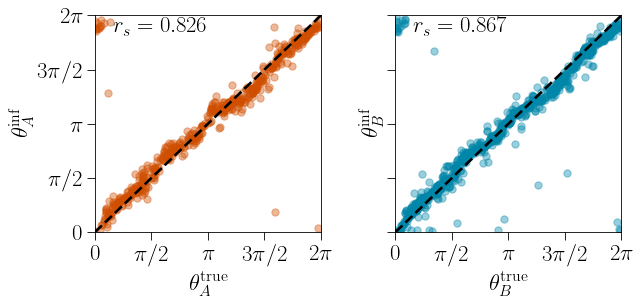

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(9,4.5), sharex=True, sharey=True)
    
alpha_val = 0.4
xx = np.linspace(0, 2*np.pi)

axs[0].scatter(true_nodes_pos, inferred_nodes_pos, marker='.', alpha=alpha_val, color=colors[0])
axs[0].plot(xx, xx, linestyle='--', color='black')
axs[0].set_xlabel(r'$\theta_A^{\mathrm{true}}$')
axs[0].set_ylabel(r'$\theta_A^{\mathrm{inf}}$')
axs[0].set_xlim(0, 2*np.pi)
axs[0].set_ylim(0, 2*np.pi)
    
# axs[0].set_title('Nodes A')
axs[0].set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], 
                  [r'$0$', r'$\pi/2$', r'$\pi$', '$3\pi/2$', '$2\pi$'])
axs[0].set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], 
                  [r'$0$', r'$\pi/2$', r'$\pi$', '$3\pi/2$', '$2\pi$'])
rho = stats.spearmanr(true_nodes_pos, inferred_nodes_pos).statistic
axs[0].text(0.5, 5.8, rf'$r_s={{{rho:.3f}}}$', )

axs[1].scatter(true_features_pos, inferred_features_pos, marker='.', alpha=alpha_val, color=colors[1])
axs[1].plot(xx, xx, linestyle='--', color='black')
axs[1].set_xlabel(r'$\theta_B^{\mathrm{true}}$')
axs[1].set_ylabel(r'$\theta_B^{\mathrm{inf}}$')
axs[1].set_xlim(0, 2*np.pi)
axs[1].set_ylim(0, 2*np.pi)

# axs[1].set_title('Nodes B')
rho = stats.spearmanr(true_features_pos, inferred_features_pos).statistic
axs[1].text(0.5, 5.8, rf'$r_s={{{rho:.3f}}}$', )

plt.tight_layout()


# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/ReSubmissionCommPhys/plots/true_vs_inf_coordinates_dim1_v1.pdf")
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/ReSubmissionCommPhys/SI/plots/true_vs_inf_coordinates_dim1_v2.pdf")


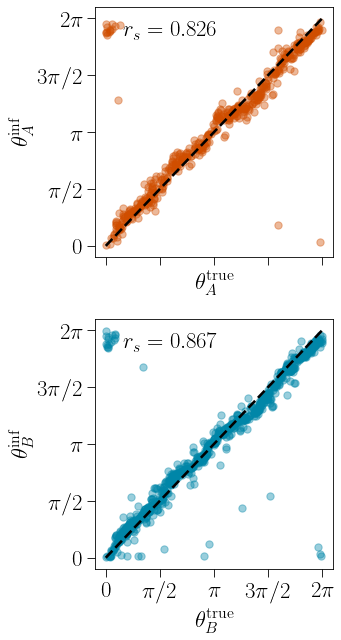

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(5, 9), sharex=True, sharey=True)

alpha_val = 0.4
xx = np.linspace(0, 2 * np.pi)

# First subplot: Nodes A
axs[0].scatter(true_nodes_pos, inferred_nodes_pos, marker='.', alpha=alpha_val, color=colors[0])
axs[0].plot(xx, xx, linestyle='--', color='black')
axs[0].set_xlabel(r'$\theta_A^{\mathrm{true}}$')
axs[0].set_ylabel(r'$\theta_A^{\mathrm{inf}}$')

# Custom ticks
axs[0].set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], 
                  [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
axs[0].set_yticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], 
                  [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])

# spearmanr correlation coefficient
rho = stats.spearmanr(true_nodes_pos, inferred_nodes_pos).statistic
axs[0].text(0.5, 5.8, rf'$r_s={{{rho:.3f}}}$')

# Second subplot: Features B
axs[1].scatter(true_features_pos, inferred_features_pos, marker='.', alpha=alpha_val, color=colors[1])
axs[1].plot(xx, xx, linestyle='--', color='black')
axs[1].set_xlabel(r'$\theta_B^{\mathrm{true}}$')
axs[1].set_ylabel(r'$\theta_B^{\mathrm{inf}}$')

# spearmanr correlation coefficient
rho = stats.spearmanr(true_features_pos, inferred_features_pos).statistic
axs[1].text(0.5, 5.8, rf'$r_s={{{rho:.3f}}}$')

plt.tight_layout()

# Uncomment to save the figure
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/true_vs_inf_coordinates_dim1_transposed.pdf")
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/true_vs_inf_coordinates_dim1_transposed.pdf")


# D=2

In [9]:
def plot_coordinates_S2(true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos):
    fig, axs = plt.subplots(3, 2, figsize=(8, 11), sharex=True, sharey=True)
    
    alpha_val = 0.4
    xx = np.linspace(min(true_nodes_pos[:, 0]), max(true_nodes_pos[:, 0]))
    
    #axs[0,0].set_title('Nodes A')
    #axs[0,1].set_title('Nodes B')
    
    # Nodes
    x_pos, y_pos = -0.9, 0.8
    axs[0,0].scatter(true_nodes_pos[:, 0], inferred_nodes_pos[:, 0], 
                     color=colors[0], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_nodes_pos[:, 0], inferred_nodes_pos[:, 0]).statistic
    axs[0,0].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[0,0].plot(xx, xx, linestyle='--', color='black')
    #axs[0,0].set_xlabel(r'$X^{\mathrm{true}}$')
    #axs[0,0].set_ylabel(r'$X^{\mathrm{inf}}$')
    axs[0,0].set_xlabel(r'$X_A^{\mathrm{true}}$')
    axs[0,0].set_ylabel(r'$X_A^{\mathrm{inf}}$')
    
    
    axs[1,0].scatter(true_nodes_pos[:, 1], inferred_nodes_pos[:, 1], 
                     color=colors[0], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_nodes_pos[:, 1], inferred_nodes_pos[:, 1]).statistic
    axs[1,0].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[1,0].plot(xx, xx, linestyle='--', color='black')
    #axs[1,0].set_xlabel(r'$Y^{\mathrm{true}}$')
    #axs[1,0].set_ylabel(r'$Y^{\mathrm{inf}}$')
    axs[1,0].set_xlabel(r'$Y_A^{\mathrm{true}}$')
    axs[1,0].set_ylabel(r'$Y_A^{\mathrm{inf}}$')
    
    axs[2,0].scatter(true_nodes_pos[:, 2], inferred_nodes_pos[:, 2], 
                     color=colors[0], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_nodes_pos[:, 2], inferred_nodes_pos[:, 2]).statistic
    axs[2,0].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[2,0].plot(xx, xx, linestyle='--', color='black')
    #axs[2,0].set_xlabel(r'$Z^{\mathrm{true}}$')
    #axs[2,0].set_ylabel(r'$Z^{\mathrm{inf}}$')
    axs[2,0].set_xlabel(r'$Z_A^{\mathrm{true}}$')
    axs[2,0].set_ylabel(r'$Z_A^{\mathrm{inf}}$')
    
    # Features
    axs[0,1].scatter(true_features_pos[:, 0], inferred_features_pos[:, 0], 
                     color=colors[1], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_features_pos[:, 0], inferred_features_pos[:, 0]).statistic
    axs[0,1].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[0,1].plot(xx, xx, linestyle='--', color='black')
    #axs[0,1].set_xlabel(r'$X^{\mathrm{true}}$')
    #axs[0,1].set_ylabel(r'$X^{\mathrm{inf}}$')
    axs[0,1].set_xlabel(r'$X_B^{\mathrm{true}}$')
    axs[0,1].set_ylabel(r'$X_B^{\mathrm{inf}}$')
    
    axs[1,1].scatter(true_features_pos[:, 1], inferred_features_pos[:, 1], 
                     color=colors[1], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_features_pos[:, 1], inferred_features_pos[:, 1]).statistic
    axs[1,1].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[1,1].plot(xx, xx, linestyle='--', color='black')
    #axs[1,1].set_xlabel(r'$Y^{\mathrm{true}}$')
    #axs[1,1].set_ylabel(r'$Y^{\mathrm{inf}}$')
    axs[1,1].set_xlabel(r'$Y_B^{\mathrm{true}}$')
    axs[1,1].set_ylabel(r'$Y_B^{\mathrm{inf}}$')
    
    axs[2,1].scatter(true_features_pos[:, 2], inferred_features_pos[:, 2], 
                     color=colors[1], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_features_pos[:, 2], inferred_features_pos[:, 2]).statistic
    axs[2,1].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[2,1].plot(xx, xx, linestyle='--', color='black')
    #axs[2,1].set_xlabel(r'$Z^{\mathrm{true}}$')
    #axs[2,1].set_ylabel(r'$Z^{\mathrm{inf}}$')
    axs[2,1].set_xlabel(r'$Z_B^{\mathrm{true}}$')
    axs[2,1].set_ylabel(r'$Z_B^{\mathrm{inf}}$')
    
    plt.tight_layout()

In [10]:
def plot_coordinates_S2_transposed(true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos):
    fig, axs = plt.subplots(2, 3, figsize=(11, 8), sharex=True, sharey=True)
    
    alpha_val = 0.4
    xx = np.linspace(min(true_nodes_pos[:, 0]), max(true_nodes_pos[:, 0]))
    x_pos, y_pos = -0.9, 0.8
    
    # Transposed Layout
    # First row: X, Y, Z for nodes
    axs[0, 0].scatter(true_nodes_pos[:, 0], inferred_nodes_pos[:, 0], 
                      color=colors[0], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_nodes_pos[:, 0], inferred_nodes_pos[:, 0]).statistic
    axs[0, 0].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$')
    axs[0, 0].plot(xx, xx, linestyle='--', color='black')
    axs[0, 0].set_xlabel(r'$X_A^{\mathrm{true}}$')
    axs[0, 0].set_ylabel(r'$X_A^{\mathrm{inf}}$')

    axs[0, 1].scatter(true_nodes_pos[:, 1], inferred_nodes_pos[:, 1], 
                      color=colors[0], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_nodes_pos[:, 1], inferred_nodes_pos[:, 1]).statistic
    axs[0, 1].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$')
    axs[0, 1].plot(xx, xx, linestyle='--', color='black')
    axs[0, 1].set_xlabel(r'$Y_A^{\mathrm{true}}$')
    axs[0, 1].set_ylabel(r'$Y_A^{\mathrm{inf}}$')

    axs[0, 2].scatter(true_nodes_pos[:, 2], inferred_nodes_pos[:, 2], 
                      color=colors[0], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_nodes_pos[:, 2], inferred_nodes_pos[:, 2]).statistic
    axs[0, 2].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$')
    axs[0, 2].plot(xx, xx, linestyle='--', color='black')
    axs[0, 2].set_xlabel(r'$Z_A^{\mathrm{true}}$')
    axs[0, 2].set_ylabel(r'$Z_A^{\mathrm{inf}}$')
    
    # Second row: X, Y, Z for features
    axs[1, 0].scatter(true_features_pos[:, 0], inferred_features_pos[:, 0], 
                      color=colors[1], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_features_pos[:, 0], inferred_features_pos[:, 0]).statistic
    axs[1, 0].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$')
    axs[1, 0].plot(xx, xx, linestyle='--', color='black')
    axs[1, 0].set_xlabel(r'$X_B^{\mathrm{true}}$')
    axs[1, 0].set_ylabel(r'$X_B^{\mathrm{inf}}$')

    axs[1, 1].scatter(true_features_pos[:, 1], inferred_features_pos[:, 1], 
                      color=colors[1], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_features_pos[:, 1], inferred_features_pos[:, 1]).statistic
    axs[1, 1].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$')
    axs[1, 1].plot(xx, xx, linestyle='--', color='black')
    axs[1, 1].set_xlabel(r'$Y_B^{\mathrm{true}}$')
    axs[1, 1].set_ylabel(r'$Y_B^{\mathrm{inf}}$')

    axs[1, 2].scatter(true_features_pos[:, 2], inferred_features_pos[:, 2], 
                      color=colors[1], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_features_pos[:, 2], inferred_features_pos[:, 2]).statistic
    axs[1, 2].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$')
    axs[1, 2].plot(xx, xx, linestyle='--', color='black')
    axs[1, 2].set_xlabel(r'$Z_B^{\mathrm{true}}$')
    axs[1, 2].set_ylabel(r'$Z_B^{\mathrm{inf}}$')

    plt.tight_layout()


In [30]:
def plot_coordinates_S2_angles(true_nodes_ang, inferred_nodes_ang,
                               true_features_ang, inferred_features_ang,
                               ):
    """
    Inputs: arrays with shape (n, 2) where [:,0]=theta, [:,1]=phi.
    If radians=False, values are interpreted as degrees for axis ticks only.
    """
    fig, axs = plt.subplots(2, 2, figsize=(9, 9))
    alpha_val = 0.4
    x_pos, y_pos = 0.05, 0.9  # annotation position in axes coords

    def _one(ax, x_true, y_inf, label_true, label_inf, color):
        xx = np.linspace(np.min(x_true), np.max(x_true), 200)
        ax.scatter(x_true, y_inf, color=color, marker='.', alpha=alpha_val)
        rho = stats.spearmanr(x_true, y_inf).statistic
        ax.text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', transform=ax.transAxes)
        ax.plot(xx, xx, linestyle='--', color='black')
        ax.set_xlabel(label_true)
        ax.set_ylabel(label_inf)

    # Nodes (A): theta, phi
    _one(axs[0,0],
         true_nodes_ang[:, 0], inferred_nodes_ang[:, 0],
         r'$\theta_A^{\mathrm{true}}$', r'$\theta_A^{\mathrm{inf}}$', colors[0])
    _one(axs[1,0],
         true_nodes_ang[:, 1], inferred_nodes_ang[:, 1],
         r'$\phi_A^{\mathrm{true}}$', r'$\phi_A^{\mathrm{inf}}$', colors[0])

    # Features (B): theta, phi
    _one(axs[0,1],
         true_features_ang[:, 0], inferred_features_ang[:, 0],
         r'$\theta_B^{\mathrm{true}}$', r'$\theta_B^{\mathrm{inf}}$', colors[1])
    _one(axs[1,1],
         true_features_ang[:, 1], inferred_features_ang[:, 1],
         r'$\phi_B^{\mathrm{true}}$', r'$\phi_B^{\mathrm{inf}}$', colors[1])

    # Optional: set canonical angle limits for readability
    #for ax in (axs[0,0], axs[0,1]):
    for ax in [axs[0,0]]:
        ax.set_xlim(0, np.pi)
        ax.set_ylim(0, np.pi)
        ax.set_xticks([0, np.pi/2, np.pi])
        ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$'])
        ax.set_yticks([0, np.pi/2, np.pi])
        ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$'])
    for ax in [axs[0,1]]:
        ax.set_xlim(0, np.pi)
        ax.set_ylim(0, np.pi)
        ax.set_xticks([0, np.pi/2, np.pi])
        ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$'])
        ax.set_yticks([0, np.pi/2, np.pi])
        ax.set_yticklabels(['', '', ''])
        
    
    # phi in [0, 2pi]
    for ax in [axs[1,0]]:#, axs[1,1]):
        ax.set_xlim(0, 2*np.pi)
        ax.set_ylim(0, 2*np.pi)
        ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
        ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
        ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
        ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    
    for ax in [axs[1,1]]:
        ax.set_xlim(0, 2*np.pi)
        ax.set_ylim(0, 2*np.pi)
        ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
        ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
        ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
        ax.set_yticklabels(['', '', '', '', ''])

            
    plt.tight_layout()
    return fig, axs


In [12]:
# p = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/check_coordinates/dim_2_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_2.7_k_n_10_g_f_2.7_N_f_1000_B_bi_3_c_0.0_i_0'
p = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/check_coordinates/dim_2_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_2.7_k_n_10_g_f_2.1_N_f_1000_B_bi_1.5_c_0.0_i_0/'
# p = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/check_coordinates/dim_2_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_3.5_k_n_10_g_f_2.1_N_f_1000_B_bi_1.5_c_0.0_i_0/'

true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos = align_compute_correlation_nodes_unipartite_bipartite(p, 2)


/home/rob/repo/f-mercator-all/f-mercator/notebooks/check_inferred_embeddings.py:57: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  np.arccos(np.dot(v, u) / (np.linalg.norm(v) * np.linalg.norm(u))))


In [13]:
from check_inferred_embeddings_S3 import euclidean_to_hyperspherical_coordinates

angles_true_nodes_pos = []
angles_inferred_nodes_pos = []
angles_true_features_pos = []
angles_inferred_features_pos = []


for i in range(len(true_nodes_pos)):
    angles_true_nodes_pos.append(euclidean_to_hyperspherical_coordinates(true_nodes_pos[i])[1:])
    angles_inferred_nodes_pos.append(euclidean_to_hyperspherical_coordinates(inferred_nodes_pos[i])[1:])
    angles_true_features_pos.append(euclidean_to_hyperspherical_coordinates(true_features_pos[i])[1:])
    angles_inferred_features_pos.append(euclidean_to_hyperspherical_coordinates(inferred_features_pos[i])[1:])
    
angles_true_nodes_pos = np.array(angles_true_nodes_pos)
angles_inferred_nodes_pos = np.array(angles_inferred_nodes_pos)
angles_true_features_pos = np.array(angles_true_features_pos)
angles_inferred_features_pos = np.array(angles_inferred_features_pos)

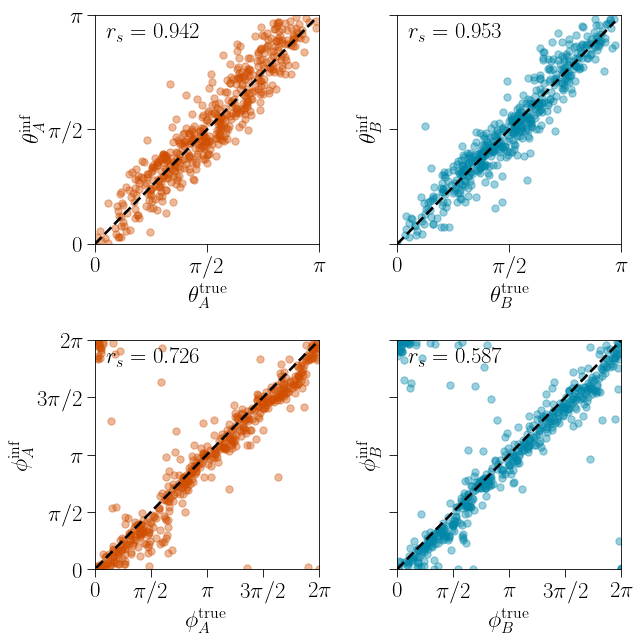

In [32]:
plot_coordinates_S2_angles(angles_true_nodes_pos, angles_inferred_nodes_pos,
                           angles_true_features_pos, angles_inferred_features_pos)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/ReSubmissionCommPhys/plots/true_vs_inf_coordinates_dim2_v1.pdf")
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/ReSubmissionCommPhys/SI/plots/true_vs_inf_coordinates_dim2_v2.pdf")


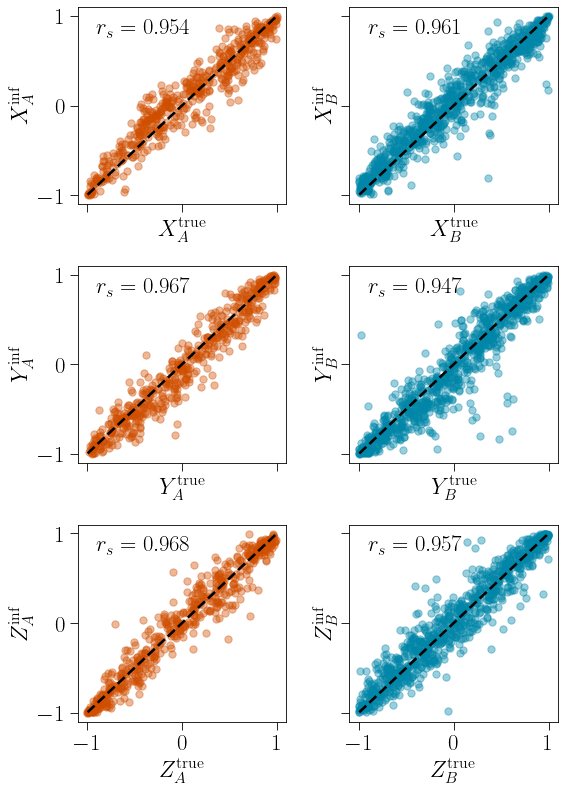

In [173]:
plot_coordinates_S2(true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos)
# plot_coordinates_S2_transposed(true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/true_vs_inf_coordinates_dim2_test.pdf")

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/true_vs_inf_coordinates_dim2_new.pdf")

# D=3

In [174]:
def plot_coordinates_S3(true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos):
    fig, axs = plt.subplots(2, 4, figsize=(14, 8), sharex=True, sharey=True)
    
    alpha_val = 0.4
    xx = np.linspace(min(true_nodes_pos[:, 0]), max(true_nodes_pos[:, 0]))
    
    # Nodes
    x_pos, y_pos = -0.9, 0.8
    axs[0,0].scatter(true_nodes_pos[:, 0], inferred_nodes_pos[:, 0], 
                     color=colors[0], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_nodes_pos[:, 0], inferred_nodes_pos[:, 0]).statistic
    axs[0,0].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[0,0].plot(xx, xx, linestyle='--', color='black')
    axs[0,0].set_xlabel(r'$X^{\mathrm{true}}$')
    axs[0,0].set_ylabel(r'$X^{\mathrm{inf}}$')
    
    axs[0,1].scatter(true_nodes_pos[:, 1], inferred_nodes_pos[:, 1], 
                     color=colors[0], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_nodes_pos[:, 1], inferred_nodes_pos[:, 1]).statistic
    axs[0,1].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[0,1].plot(xx, xx, linestyle='--', color='black')
    axs[0,1].set_xlabel(r'$Y^{\mathrm{true}}$')
    axs[0,1].set_ylabel(r'$Y^{\mathrm{inf}}$')
    
    axs[0,2].scatter(true_nodes_pos[:, 2], inferred_nodes_pos[:, 2], 
                     color=colors[0], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_nodes_pos[:, 2], inferred_nodes_pos[:, 2]).statistic
    axs[0,2].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[0,2].plot(xx, xx, linestyle='--', color='black')
    axs[0,2].set_xlabel(r'$Z^{\mathrm{true}}$')
    axs[0,2].set_ylabel(r'$Z^{\mathrm{inf}}$')
    
    axs[0,3].scatter(true_nodes_pos[:, 3], inferred_nodes_pos[:, 3], 
                     color=colors[0], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_nodes_pos[:, 3], inferred_nodes_pos[:, 3]).statistic
    axs[0,3].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[0,3].plot(xx, xx, linestyle='--', color='black')
    axs[0,3].set_xlabel(r'$W^{\mathrm{true}}$')
    axs[0,3].set_ylabel(r'$W^{\mathrm{inf}}$')
    axs[0,3].text(1.1, 0.5, 'Nodes A', horizontalalignment='center',
        verticalalignment='center', rotation=270, transform=axs[0,3].transAxes, fontsize=26)
    
    # Features
    axs[1,0].scatter(true_features_pos[:, 0], inferred_features_pos[:, 0], 
                     color=colors[1], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_features_pos[:, 0], inferred_features_pos[:, 0]).statistic
    axs[1,0].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[1,0].plot(xx, xx, linestyle='--', color='black')
    axs[1,0].set_xlabel(r'$X^{\mathrm{true}}$')
    axs[1,0].set_ylabel(r'$X^{\mathrm{inf}}$')
    
    axs[1,1].scatter(true_features_pos[:, 1], inferred_features_pos[:, 1], 
                     color=colors[1], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_features_pos[:, 1], inferred_features_pos[:, 1]).statistic
    axs[1,1].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[1,1].plot(xx, xx, linestyle='--', color='black')
    axs[1,1].set_xlabel(r'$Y^{\mathrm{true}}$')
    axs[1,1].set_ylabel(r'$Y^{\mathrm{inf}}$')
    
    axs[1,2].scatter(true_features_pos[:, 2], inferred_features_pos[:, 2], 
                     color=colors[1], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_features_pos[:, 2], inferred_features_pos[:, 2]).statistic
    axs[1,2].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[1,2].plot(xx, xx, linestyle='--', color='black')
    axs[1,2].set_xlabel(r'$Z^{\mathrm{true}}$')
    axs[1,2].set_ylabel(r'$Z^{\mathrm{inf}}$')
    
    axs[1,3].scatter(true_features_pos[:, 3], inferred_features_pos[:, 3], 
                     color=colors[1], marker='.', alpha=alpha_val)
    rho = stats.spearmanr(true_features_pos[:, 3], inferred_features_pos[:, 3]).statistic
    axs[1,3].text(x_pos, y_pos, rf'$r_s={{{rho:.3f}}}$', )
    axs[1,3].plot(xx, xx, linestyle='--', color='black')
    axs[1,3].set_xlabel(r'$W^{\mathrm{true}}$')
    axs[1,3].set_ylabel(r'$W^{\mathrm{inf}}$')
    axs[1,3].text(1.1, 0.5, 'Nodes B', horizontalalignment='center',
        verticalalignment='center', rotation=270, transform=axs[1,3].transAxes, fontsize=26)
    
    plt.tight_layout()

In [175]:
def plot_coordinates_S3_angles(true_nodes_ang, inferred_nodes_ang,
                               true_features_ang, inferred_features_ang,
                               radians=True):
    """
    Inputs: arrays with shape (n, 3):
      [:,0]=theta_1 in [0, pi], [:,1]=theta_2 in [0, pi], [:,2]=phi in [0, 2pi] if radians=True.
    """
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=False)
    alpha_val = 0.4
    x_pos, y_pos = 0.05, 0.9  # axes coords for rho label

    def _one(ax, x_true, y_inf, label_true, label_inf, color):
        lo = min(np.min(x_true), np.min(y_inf))
        hi = max(np.max(x_true), np.max(y_inf))
        xx = np.linspace(lo, hi, 200)
        ax.scatter(x_true, y_inf, color=color, marker='.', alpha=alpha_val)
        rs = stats.spearmanr(x_true, y_inf).statistic
        ax.text(x_pos, y_pos, rf'$r_s={{{rs:.3f}}}$', transform=ax.transAxes)
        ax.plot(xx, xx, linestyle='--', color='black')
        ax.set_xlabel(label_true)
        ax.set_ylabel(label_inf)

    # Nodes (A): theta1, theta2, phi
    _one(axs[0,0],
         true_nodes_ang[:, 0], inferred_nodes_ang[:, 0],
         r'$\theta_{1,A}^{\mathrm{true}}$', r'$\theta_{1,A}^{\mathrm{inf}}$', colors[0])
    _one(axs[0,1],
         true_nodes_ang[:, 1], inferred_nodes_ang[:, 1],
         r'$\theta_{2,A}^{\mathrm{true}}$', r'$\theta_{2,A}^{\mathrm{inf}}$', colors[0])
    _one(axs[0,2],
         true_nodes_ang[:, 2], inferred_nodes_ang[:, 2],
         r'$\phi_{A}^{\mathrm{true}}$', r'$\phi_{A}^{\mathrm{inf}}$', colors[0])

    # Features (B): theta1, theta2, phi
    _one(axs[1,0],
         true_features_ang[:, 0], inferred_features_ang[:, 0],
         r'$\theta_{1,B}^{\mathrm{true}}$', r'$\theta_{1,B}^{\mathrm{inf}}$', colors[1])
    _one(axs[1,1],
         true_features_ang[:, 1], inferred_features_ang[:, 1],
         r'$\theta_{2,B}^{\mathrm{true}}$', r'$\theta_{2,B}^{\mathrm{inf}}$', colors[1])
    _one(axs[1,2],
         true_features_ang[:, 2], inferred_features_ang[:, 2],
         r'$\phi_{B}^{\mathrm{true}}$', r'$\phi_{B}^{\mathrm{inf}}$', colors[1])

    # Canonical limits and ticks
    if radians:
        # theta_1, theta_2 in [0, pi]
        for ax in (axs[0,0], axs[0,1], axs[1,0], axs[1,1]):
            ax.set_xlim(0, np.pi); ax.set_ylim(0, np.pi)
            ax.set_xticks([0, np.pi/2, np.pi])
            ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$'])
            ax.set_yticks([0, np.pi/2, np.pi])
            ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$'])
        # phi in [0, 2pi]
        for ax in (axs[0,2], axs[1,2]):
            ax.set_xlim(0, 2*np.pi); ax.set_ylim(0, 2*np.pi)
            xt = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
            ax.set_xticks(xt)
            ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
            ax.set_yticks(xt)
            ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    else:
        for ax in (axs[0,0], axs[0,1], axs[1,0], axs[1,1]):
            ax.set_xlim(0, 180); ax.set_ylim(0, 180)
            ax.set_xticks([0, 90, 180]); ax.set_yticks([0, 90, 180])
        for ax in (axs[0,2], axs[1,2]):
            ax.set_xlim(0, 360); ax.set_ylim(0, 360)
            ax.set_xticks([0, 90, 180, 270, 360])
            ax.set_yticks([0, 90, 180, 270, 360])

    plt.tight_layout()
    return fig, axs


In [176]:
%%time

# p = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/check_coordinates/dim_3_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_3.5_k_n_10_g_f_3.5_N_f_1000_B_bi_3_c_0.0_i_0'
p = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/check_coordinates/dim_3_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_2.7_k_n_10_g_f_2.7_N_f_1000_B_bi_1.5_c_0.0_i_0/'

true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos = align_compute_correlation_nodes_unipartite_bipartite(p, 3)

CPU times: user 1min 11s, sys: 1min 29s, total: 2min 40s
Wall time: 2min 40s


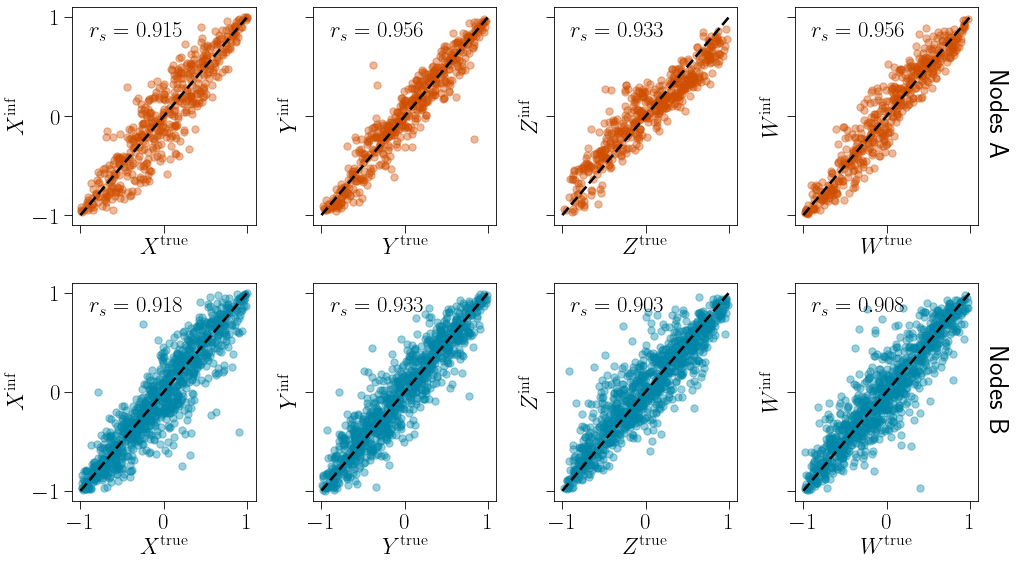

In [177]:
plot_coordinates_S3(true_nodes_pos, inferred_nodes_pos, true_features_pos, inferred_features_pos)


In [178]:
from check_inferred_embeddings_S3 import euclidean_to_hyperspherical_coordinates

angles_true_nodes_pos = []
angles_inferred_nodes_pos = []
angles_true_features_pos = []
angles_inferred_features_pos = []


for i in range(len(true_nodes_pos)):
    angles_true_nodes_pos.append(euclidean_to_hyperspherical_coordinates(true_nodes_pos[i])[1:])
    angles_inferred_nodes_pos.append(euclidean_to_hyperspherical_coordinates(inferred_nodes_pos[i])[1:])
    angles_true_features_pos.append(euclidean_to_hyperspherical_coordinates(true_features_pos[i])[1:])
    angles_inferred_features_pos.append(euclidean_to_hyperspherical_coordinates(inferred_features_pos[i])[1:])
    
angles_true_nodes_pos = np.array(angles_true_nodes_pos)
angles_inferred_nodes_pos = np.array(angles_inferred_nodes_pos)
angles_true_features_pos = np.array(angles_true_features_pos)
angles_inferred_features_pos = np.array(angles_inferred_features_pos)

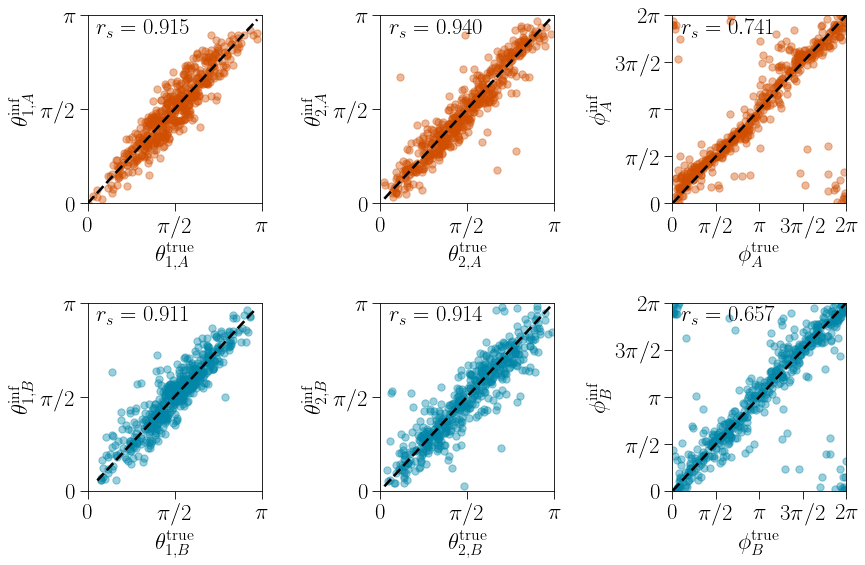

In [180]:
plot_coordinates_S3_angles(angles_true_nodes_pos, angles_inferred_nodes_pos,
                           angles_true_features_pos, angles_inferred_features_pos)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/ReSubmissionCommPhys/SI/plots/true_vs_inf_coordinates_dim3_v2.pdf")
